In [12]:
# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

import time

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

In [2]:
from six.moves import urllib
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1)
    mnist.target = mnist.target.astype(np.int64)
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')
X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [7]:
#number of features after dimension reduction
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [11]:
np.sum(pca.explained_variance_ratio_)

0.950365507264592

In [8]:
d

154

In [23]:
#or another way to find the number
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)
pca.n_components_

154

In [24]:
np.sum(pca.explained_variance_ratio_)

0.950365507264592

In [25]:
#recover to full dimension from 154 dimension 
X_recovered = pca.inverse_transform(X_reduced)

In [26]:
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

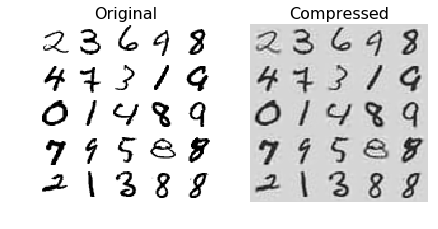

In [27]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)

In [28]:
X_reduced_pca = X_reduced

In [29]:
#IPCA
n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)
    
X_reduced = inc_pca.transform(X_train)

In [30]:
X_recovered_inc_pca = inc_pca.inverse_transform(X_reduced)

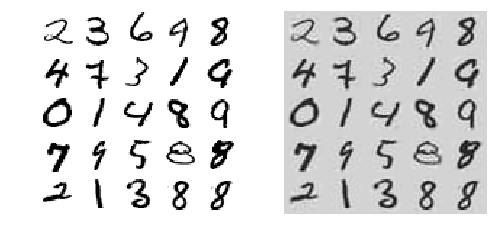

In [31]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.subplot(122)
plot_digits(X_recovered_inc_pca[::2100])
plt.tight_layout()

In [32]:
X_reduced_inc_pca = X_reduced

In [33]:
#comparing the results of transforming MNIST using regular PCA 
#and incremental PCA. the means are equal
np.allclose(pca.mean_, inc_pca.mean_)

True

In [34]:
#But the results are not exactly identical. 
#Incremental PCA gives a very good approximate solution, 
#but it's not perfect:
np.allclose(X_reduced_pca, X_reduced_inc_pca)

False

In [39]:
#Randomized PCA
rnd_pca = PCA(n_components=154, random_state=42, svd_solver="randomized")
X_reduced = rnd_pca.fit_transform(X_train)
rnd_pca.n_components_

154

In [40]:
X_reduced_rnd_pca = X_reduced

In [6]:
#LDA dimentionality reduction technique
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=2)
X_mnist = mnist["data"]
y_mnist = mnist["target"]
lda.fit(X_mnist, y_mnist)
X_reduced_lda = lda.transform(X_mnist)

/Users/GeorgeQiao/anaconda/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [4]:
#perform random forest classifier, calculate time and accuracy
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)

In [6]:
t0 = time.time()
rnd_clf.fit(X_train, y_train)
t1 = time.time()
print("Training took {:.2f}s".format(t1 - t0))

Training took 3.77s


In [8]:
y_pred = rnd_clf.predict(X_test)
accuracy_score(y_pred, y_test)

0.9469714285714286

In [9]:
#perform pca and then random forest classifier, calculate time and accuracy
pca = PCA(n_components=0.95)
X_train_reduced = pca.fit_transform(X_train)

In [10]:
rnd_clf2 = RandomForestClassifier(n_estimators=10, random_state=42)
t0 = time.time()
rnd_clf2.fit(X_train_reduced, y_train)
t1 = time.time()
print("Training took {:.2f}s".format(t1 - t0))

Training took 7.44s


In [11]:
X_test_reduced = pca.transform(X_test)

y_pred = rnd_clf2.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

0.8874857142857143

In [13]:
#appearently pca does not match well with the random forest classidier
#next let's try the logistic regression model
log_clf = LogisticRegression(multi_class="multinomial", solver="lbfgs", random_state=42)
t0 = time.time()
log_clf.fit(X_train, y_train)
t1 = time.time()

/Users/GeorgeQiao/anaconda/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [14]:
print("Training took {:.2f}s".format(t1 - t0))

Training took 13.32s


In [15]:
y_pred = log_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9222857142857143

In [16]:
#logistic regression with reduced data
log_clf2 = LogisticRegression(multi_class="multinomial", solver="lbfgs", random_state=42)
t0 = time.time()
log_clf2.fit(X_train_reduced, y_train)
t1 = time.time()

/Users/GeorgeQiao/anaconda/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [17]:
print("Training took {:.2f}s".format(t1 - t0))

Training took 3.67s


In [18]:
y_pred = log_clf2.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

0.918